# **Лабораторная работа №6**
## **Решение задачи классификации методом решающих деревьев**
## **Вариант 6: Отток клиентов**

**Цель работы**: научиться решать задачу классификации методами решающих деревьев и ансамблей на их основе.

**Основные задачи**:
* освоить метод Random Forest (Случайный лес) – алгоритма машинного обучения, относящегося к классу ансамблевых методов;
* оценить эффективность алгоритма на практическом примере;
* изучение методов визуализации модели и оценки ее корректности.

Выполним анализ набора данных: "Отток клиентов". Набор данных содержит информацию о клиентах маркетингового агентства, включая их демографические характеристики, историю покупок и использование услуг компании. Данные предназначены для анализа оттока клиентов и выявления факторов, которые увеличивают вероятность того, что клиент перестанет пользоваться услугами агентства.

Набор данных включает следующие атрибуты:
*   Name – имя последнего контактного лица
*   Age – возраст клиента
*   Total Purchase – общее количество купленных объявлений
*   Account Manager – 0/1, назначен ли менеджер по работе с клиентами
*   Years – количество лет в качестве клиента
*   Num sites – количество веб-сайтов, которые использует клиент
в неделю, потраченных на физическую активность, в диапазоне от 0 до 10;
*   Onboard date – дата регистрации последнего контактного лица
алкоголя, потребляемых в неделю, в диапазоне от 0 до 5;
*   Location – адрес штаб-квартиры клиента
*   Company – название компании-клиента
*   Churn – ушел или нет (0/1)


In [72]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Для воспроисводимости результатов
np.random.seed(42)

## 1. Загрузка датасета

In [73]:
# Загружаем набор данных о клиентах (бинарная классификация)
data = pd.read_csv("customer_churn.csv")
data.head()

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company,Churn
0,Cameron Williams,42.0,11066.80,0,7.22,8.0,2013-08-30 07:00:40,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC,1
1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,2013-08-13 00:38:46,"6157 Frank Gardens Suite 019 Carloshaven, RI 1...",Wilson PLC,1
2,Eric Lozano,38.0,12884.75,0,6.67,12.0,2016-06-29 06:20:07,"1331 Keith Court Alyssahaven, DE 90114","Miller, Johnson and Wallace",1
3,Phillip White,42.0,8010.76,0,6.71,10.0,2014-04-22 12:43:12,"13120 Daniel Mount Angelabury, WY 30645-4695",Smith Inc,1
4,Cynthia Norton,37.0,9191.58,0,5.56,9.0,2016-01-19 15:31:15,"765 Tricia Row Karenshire, MH 71730",Love-Jones,1


## 2. Первичный анализ данных

In [74]:
data.shape

(900, 10)

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Names            900 non-null    object 
 1   Age              900 non-null    float64
 2   Total_Purchase   900 non-null    float64
 3   Account_Manager  900 non-null    int64  
 4   Years            900 non-null    float64
 5   Num_Sites        900 non-null    float64
 6   Onboard_date     900 non-null    object 
 7   Location         900 non-null    object 
 8   Company          900 non-null    object 
 9   Churn            900 non-null    int64  
dtypes: float64(4), int64(2), object(4)
memory usage: 70.4+ KB


In [76]:
data.describe()

,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,41.816667,10062.824033,0.481111,5.273156,8.587778,0.166667
std,6.127560,2408.644532,0.499921,1.274449,1.764836,0.372885
min,22.000000,100.000000,0.000000,1.000000,3.000000,0.000000
25%,38.000000,8497.122500,0.000000,4.450000,7.000000,0.000000
50%,42.000000,10045.870000,0.000000,5.215000,8.000000,0.000000
75%,46.000000,11760.105000,1.000000,6.110000,10.000000,0.000000
max,65.000000,18026.010000,1.000000,9.150000,14.000000,1.000000


## 3. Проверяем наличие пропущенных значений

In [77]:
print(data.isnull().sum())

Names              0
Age                0
Total_Purchase     0
Account_Manager    0
Years              0
Num_Sites          0
Onboard_date       0
Location           0
Company            0
Churn              0
dtype: int64


## 4. Исключим невлияющие категориальные признаки

In [78]:
data_copy = data.copy()
cat_feat = ['Names', 'Location', 'Company', 'Onboard_date']
data_copy.drop(cat_feat, axis=1, inplace=True)
data_copy.head()

,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
0,42.0,11066.80,0,7.22,8.0,1
1,41.0,11916.22,0,6.50,11.0,1
2,38.0,12884.75,0,6.67,12.0,1
3,42.0,8010.76,0,6.71,10.0,1
4,37.0,9191.58,0,5.56,9.0,1


## 5. Разделяем данные на признаки и целевую переменную

In [79]:
# Целевая переменная
y = data_copy['Churn']
# Признаки
X = data_copy.drop('Churn', axis=1)
X.head()

,Age,Total_Purchase,Account_Manager,Years,Num_Sites
0,42.0,11066.80,0,7.22,8.0
1,41.0,11916.22,0,6.50,11.0
2,38.0,12884.75,0,6.67,12.0
3,42.0,8010.76,0,6.71,10.0
4,37.0,9191.58,0,5.56,9.0


## 6. Применяем операцию нормализации для численной устойчивости

In [80]:
from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
X = standardizer.fit_transform(X)
X

array([[ 0.0299361 ,  0.41705373, -0.96290958,  1.52844634, -0.33323478],
       [-0.13335172,  0.76990459, -0.96290958,  0.96318219,  1.36758544],
       [-0.6232152 ,  1.172234  , -0.96290958,  1.09664734,  1.93452551],
       ...,
       [ 0.51979958,  0.82804427, -0.96290958,  0.14668954, -2.60099507],
       [ 1.49952654, -1.47255646,  1.03851911,  0.15454043,  0.80064537],
       [-0.45992738, -0.31039844,  1.03851911, -0.19874967,  0.80064537]])

In [97]:
# Сохраняем имена признаков и делаем DataFrame обратно, чтобы потом оценить важность признаков
feature_names = data_copy.drop('Churn', axis=1).columns
X = pd.DataFrame(X, columns=feature_names)

## 7. Разделение данных на обучающую и тестовую выборки

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Обучающая выборка: {X_train.shape[0]} samples")
print(f"Тестовая выборка: {X_test.shape[0]} samples")

Обучающая выборка: 630 samples
Тестовая выборка: 270 samples


## 8. Построение и оценка базового дерева решений

In [83]:
# Создаем и обучаем модель дерева решений без настройки гиперпараметров
base_dt = DecisionTreeClassifier(random_state=42)
base_dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [84]:
# Делаем прогнозы и оцениваем точность
y_pred_base = base_dt.predict(X_test)
accuracy_base = accuracy_score(y_test, y_pred_base)
print(f"Точность базового дерева на тестовой выборке: {accuracy_base:.4f}")

Точность базового дерева на тестовой выборке: 0.8370


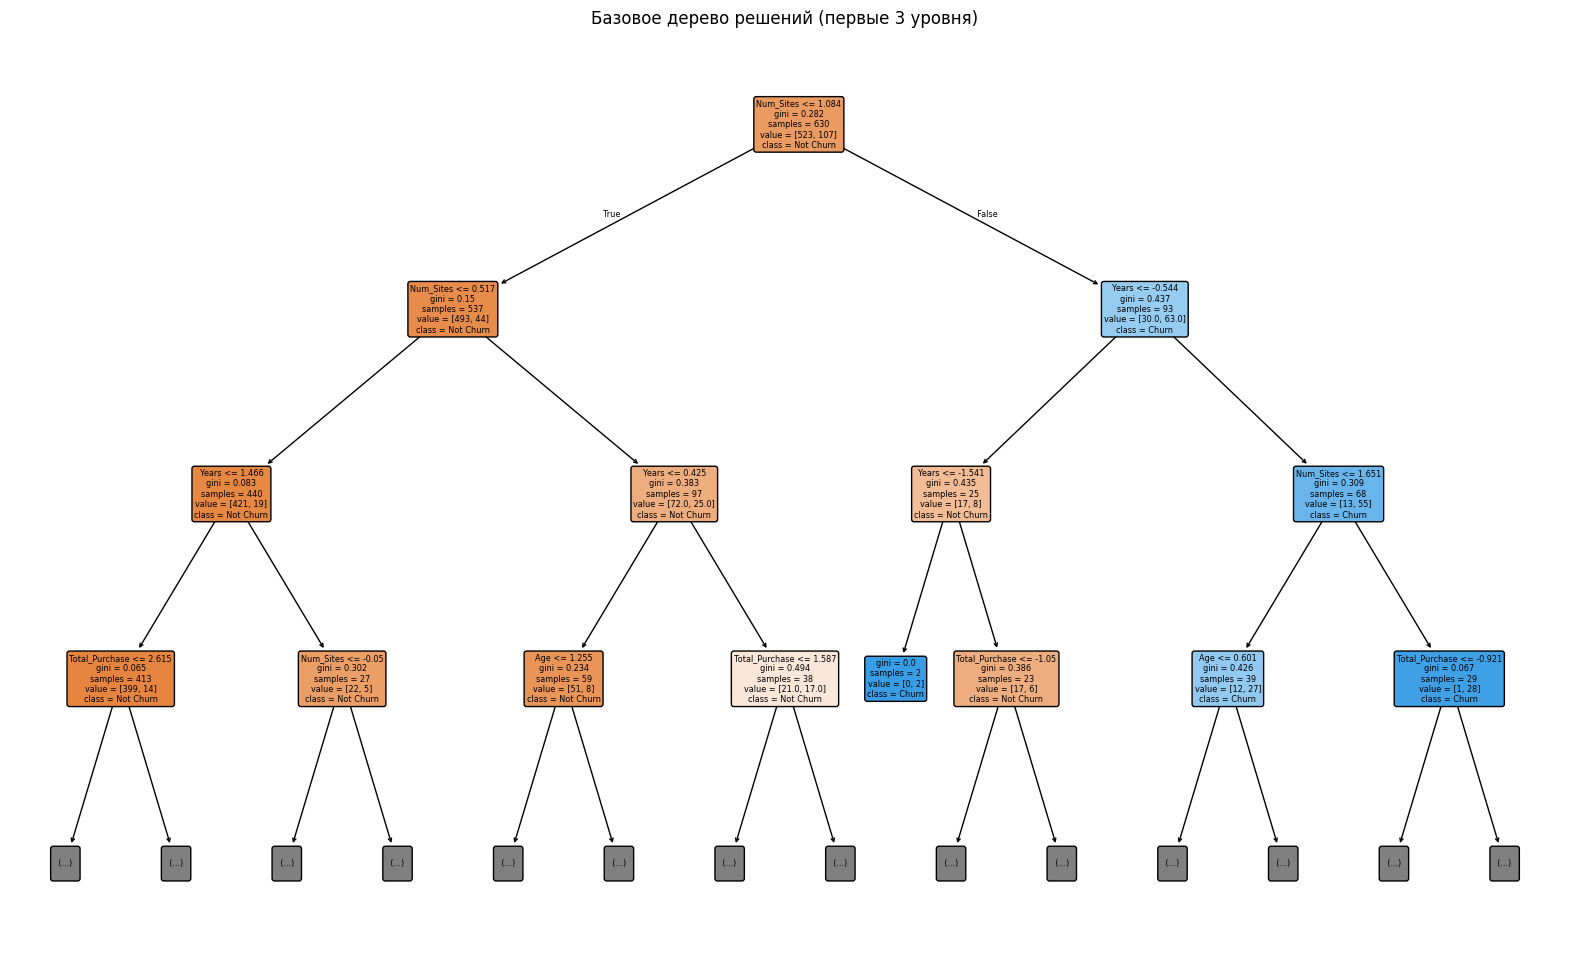

In [85]:
# Визуализация дерева решений (первые 3 уровня)
plt.figure(figsize=(20, 12))
plot_tree(base_dt, filled=True, feature_names=X.columns, class_names=['Not Churn', 'Churn'], rounded=True, max_depth=3)
plt.title("Базовое дерево решений (первые 3 уровня)")
plt.show()

## 9. Создание и обучение модели Random Forest

In [86]:
# Создаем модель Random Forest
# n_estimators - количество деревбев в лесу
# random_state - для воспроизводимости результатов
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Обучаем модель на обучающих данных
rf_model.fit(X_train, y_train)

print("Модель Random Forest обучена!")

Модель Random Forest обучена!


## 10. Прогнозирование и оценка модели

In [87]:
# Делаем прогнозы на тестовой выборке
y_pred = rf_model.predict(X_test)

# Оцениваем точность модели
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели на тестовой выборке: {accuracy:.4f}")

Точность модели на тестовой выборке: 0.8815


In [88]:
# Выводим подробный отчет по классификации
target_names = ['Not Churn', 'Churn']
print("\n" + "="*50)
print("Отчет по классификации:")
print("="*50)
print(classification_report(y_test, y_pred, target_names=target_names))


Отчет по классификации:
              precision    recall  f1-score   support

   Not Churn       0.90      0.96      0.93       227
       Churn       0.70      0.44      0.54        43

    accuracy                           0.88       270
   macro avg       0.80      0.70      0.74       270
weighted avg       0.87      0.88      0.87       270



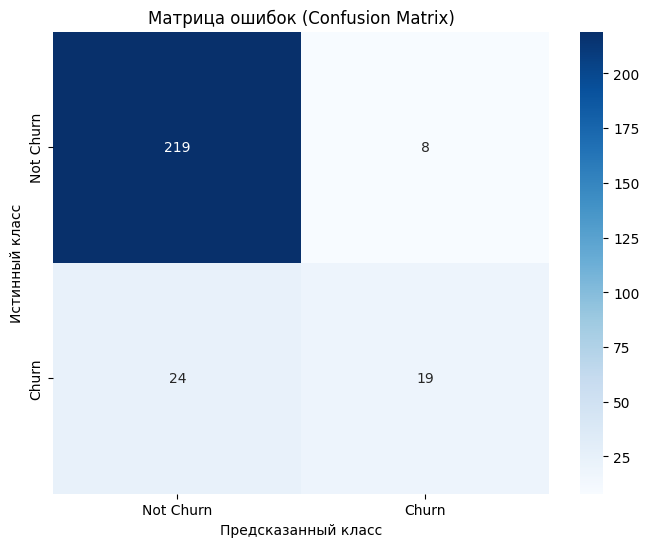

In [89]:
# Строим матрицу ошибок
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title("Матрица ошибок (Confusion Matrix)")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.show()

## 11. Анализ важности признаков

In [90]:
# Важность признаков на основе среднего уменьшения неоднородности
feature_importances = rf_model.feature_importances_
features_df = pd.DataFrame({"feature": X.columns, "importance": feature_importances})
features_df = features_df.sort_values("importance", ascending=False)

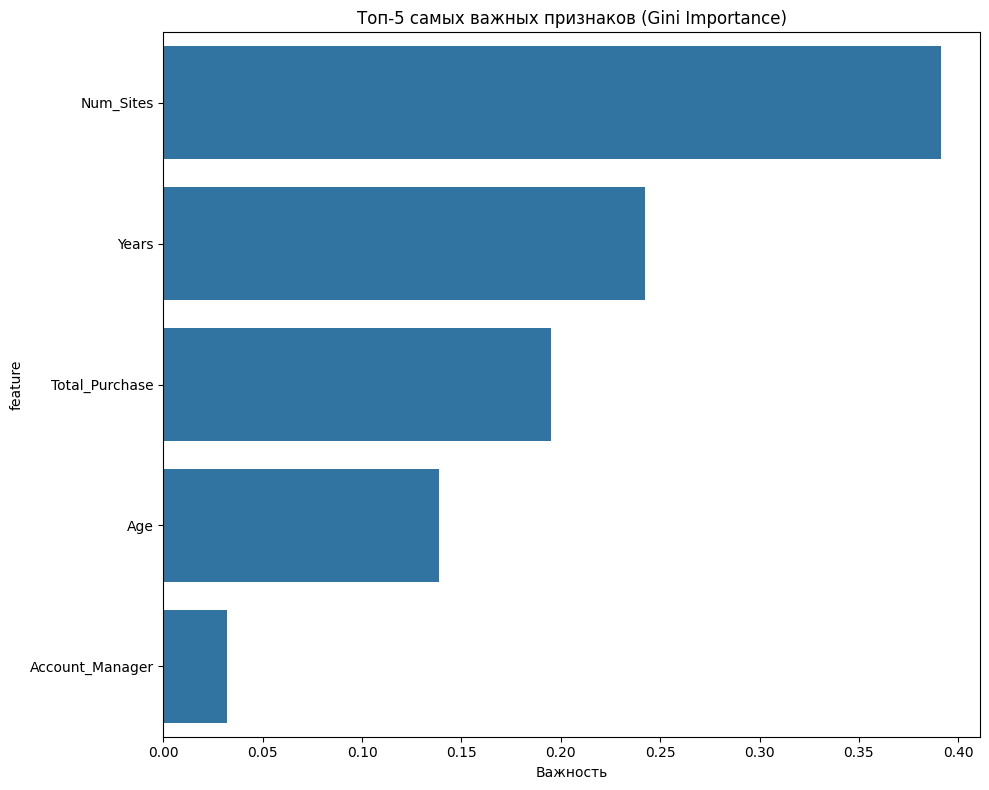

In [91]:
# Визуализация важности признаков
plt.figure(figsize=(10, 8))
sns.barplot(x="importance", y="feature", data=features_df.head(5)) # Покажем топ-5 признаков
plt.title("Топ-5 самых важных признаков (Gini Importance)")
plt.xlabel("Важность")
plt.tight_layout()
plt.show()


In [92]:
# Вывод таблицы с важность признаков
print("Топ-5 самых важных признаков:")
print(features_df.head(5))

Топ-5 самых важных признаков:
           feature  importance
4        Num_Sites    0.391388
3            Years    0.242522
1   Total_Purchase    0.194977
0              Age    0.138905
2  Account_Manager    0.032209


## 12. Подбор гиперпараметров

In [93]:
from sklearn.model_selection import GridSearchCV

# Определяем сетку параметров для перебора
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

In [94]:
# Создаем модель для поиска
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring="accuracy", n_jobs=-1)

# Запускаем поиск (может занять некоторое время)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [95]:
# Выводим лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая точность при кросс-валидации: {:.4f}".format(grid_search.best_score_))

Лучшие параметры: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Лучшая точность при кросс-валидации: 0.8857


In [96]:
# Оцениваем лучшую модель на тестовых данных
best_rf_model = grid_search.best_estimator_
y_pred_best = best_rf_model.predict(X_test)
best_accuracy = accuracy_score(y_test, y_pred_best)
print(f"Точность улучшенной модели на тестовой выборке: {best_accuracy:.4f}")

Точность улучшенной модели на тестовой выборке: 0.8889
